In [0]:
import requests
import json
import math
from datetime import datetime, timedelta
from pyspark.sql import Row
from pyspark.sql.functions import col, expr, when

'''Using datetime to set todays date so whenever the application is run we always see an accurate record of the past 25 and next 25 years'''
today = datetime.today()
past_25_years = today - timedelta(days=25*365)
future_25_years = today + timedelta(days=25*365)

START_DATE = past_25_years.strftime("%Y-%m-%d")
END_DATE = future_25_years.strftime("%Y-%m-%d")
API_KEY = "6fFILj16yX0WFbGX5deyc2End7lGJG4Spuid9pH1"
URL = f"https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key={API_KEY}"

'''API call - limited to 7 days per request'''
response = requests.get(URL)
response.raise_for_status()

'''See the data in a readable format'''
data = response.json()
raw_data = json.dumps(data, indent=2)
readable_near_earth_objects = json.dumps(data["near_earth_objects"], indent=2)

'''filtered to only have near earth object data '''
near_earth_objects = data["near_earth_objects"]


In [0]:
def calculate_orbital_period(miss_distance_km):
  '''calculates the orbital period based of the miss distance using keplers third law. returns the period in minutes which will be used in the analysis'''
  miss_distance_m = miss_distance_km * 1000
  gravitational_constant =  6.67430
  earth_mass_kg = 5.972e24
  gravitational_strength = gravitational_constant * earth_mass_kg
  total_seconds = 2 * math.pi * math.sqrt(miss_distance_m**3 / gravitational_strength)
  total_minutes = total_seconds / 60
  
  return int(total_minutes)

In [0]:
'''create empty list in preparation for adding required data'''
near_earth_objects_list = []
close_approach_list = []

'''loop through the data by each date then loop through the individual objects of each date. .items() allows us to loop through retrieving key:value pairs'''
for date, neo_obj in near_earth_objects.items():
    for obj in neo_obj:
        diameter_min = obj["estimated_diameter"]["kilometers"]["estimated_diameter_min"]
        diameter_max = obj["estimated_diameter"]["kilometers"]["estimated_diameter_max"]
        avg_diameter = round((diameter_min + diameter_max) / 2, 2)
        orbital_period_mins = calculate_orbital_period(float(obj["close_approach_data"][0]["miss_distance"]["kilometers"]))
        
        # append data to the near earth object list. Row creates a single row of data in the pyspark dataframe
        near_earth_objects_list.append(Row(
            id=obj["id"],
            neo_reference_id=obj["neo_reference_id"],
            name=obj["name"],
            diameter_km=avg_diameter,
            is_potentially_hazardous=obj["is_potentially_hazardous_asteroid"],
            orbital_period_minutes=orbital_period_mins
        ))

        for approach in obj["close_approach_data"]:
          approach_date = datetime.strptime(approach["close_approach_date"], "%Y-%m-%d")
          # filter approach date for the past and future 25 years (50 year window)
          if past_25_years <= approach_date <= future_25_years:
              close_approach_list.append(Row(
                  neo_id=obj["id"],
                  close_approach_date=approach["close_approach_date"],
                  distance_from_earth_km=round(float(approach["miss_distance"]["kilometers"]),2),
                  diameter_km=avg_diameter,
                  is_potentially_hazardous=obj["is_potentially_hazardous_asteroid"]
              ))

In [0]:
neo_df = spark.createDataFrame(near_earth_objects_list)
'''add a new column for hazard classification. when true its hazardous, when false not hazardous'''
neo_df = neo_df.withColumn(
    "hazard_classification", when(col("is_potentially_hazardous") == 'true', "potentially hazardous")
    .otherwise("non-hazardous")
)

'''drop redundant column'''
neo_df = neo_df.drop("is_potentially_hazardous")

neo_df.show()

+--------+----------------+------------------+-----------+----------------------+---------------------+
|      id|neo_reference_id|              name|diameter_km|orbital_period_minutes|hazard_classification|
+--------+----------------+------------------+-----------+----------------------+---------------------+
| 2465633|         2465633| 465633 (2009 JR5)|       0.35|                   159| potentially hazar...|
| 3426410|         3426410|       (2008 QV11)|       0.23|                   126|        non-hazardous|
| 3553060|         3553060|       (2010 XT10)|       0.02|                   330|        non-hazardous|
| 3726710|         3726710|         (2015 RC)|       0.06|                     4|        non-hazardous|
| 3727181|         3727181|       (2015 RO36)|       0.11|                    12|        non-hazardous|
| 3727639|         3727639|       (2015 RN83)|       0.19|                    66|        non-hazardous|
| 3730577|         3730577|      (2015 TX237)|       0.09|      

In [0]:
approach_df = spark.createDataFrame(close_approach_list)

# Lunar distance in km (distance between earth and moon)
LD = 384400

approach_df = approach_df.withColumn(
    "distance_category",
    when(col("distance_from_earth_km") < LD, "extremely_close")
    .when(col("distance_from_earth_km") < 4_000_000, "close")
    .when(col("distance_from_earth_km") < 10_000_000, "moderate_distance")
    .otherwise("distant")
)

# The below 2 operations are duplicate code i've used on the neo_df to add and remove required / redundant columns 
approach_df = approach_df.withColumn(
    "hazard_classification", when(col("is_potentially_hazardous") == 'true', "potentially hazardous").otherwise("non-hazardous")
)
approach_df = approach_df.drop("is_potentially_hazardous")

'''allow the filtering of objects by size ranges'''
approach_df = approach_df.withColumn(
    "size_category",
    when(col("diameter_km") < 0.1, "small")
    .when(col("diameter_km") <= 0.7, "medium")
    .otherwise("large")
)

approach_df.show()

+--------+-------------------+----------------------+-----------+-----------------+---------------------+-------------+
|  neo_id|close_approach_date|distance_from_earth_km|diameter_km|distance_category|hazard_classification|size_category|
+--------+-------------------+----------------------+-----------+-----------------+---------------------+-------------+
| 2465633|         2015-09-08|         4.529029823E7|       0.35|          distant| potentially hazar...|       medium|
| 3426410|         2015-09-08|         3.876455855E7|       0.23|          distant|        non-hazardous|       medium|
| 3553060|         2015-09-08|         7.356378239E7|       0.02|          distant|        non-hazardous|        small|
| 3726710|         2015-09-08|             4027962.7|       0.06|moderate_distance|        non-hazardous|        small|
| 3727181|         2015-09-08|             8086032.0|       0.11|moderate_distance|        non-hazardous|       medium|
| 3727639|         2015-09-08|         2

In [0]:
%sql
-- drop the table when altering code above for testing purposes
drop table if exists near_earth_objects;
drop table if exists close_approaches_with_earth;

In [0]:
'''write the data from the PySpark Dataframes into tables'''
neo_df.write.mode("overwrite").saveAsTable("near_earth_objects")
approach_df.write.mode("overwrite").saveAsTable("close_approaches_with_earth")

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [0]:
'''convert spark df to a pandas df to use with matplotlib and seaborn'''
neo_pd = neo_df.toPandas()
approach_pd = approach_df.toPandas()

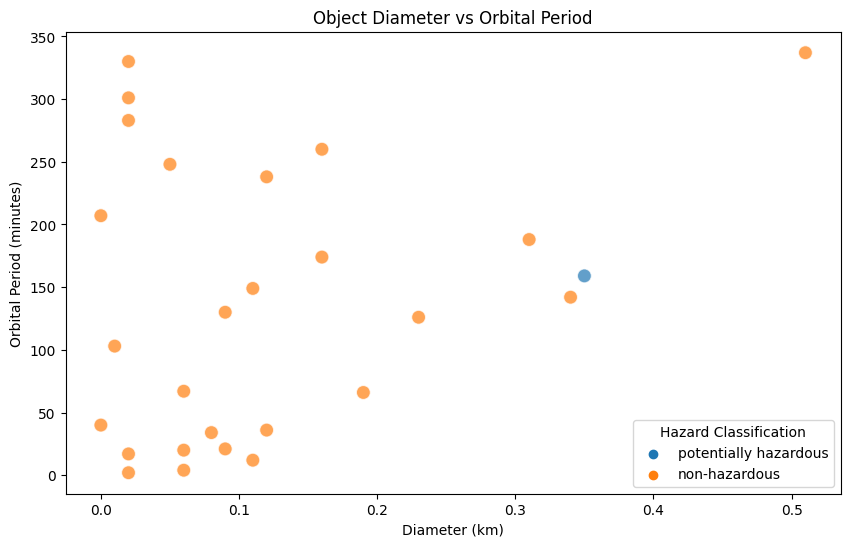

In [0]:
'''scatter plot graph showing relationship between diameter and orbital period categorised by hazard classification'''

plt.figure(figsize=(10,6))
sns.scatterplot(data=neo_pd, x="diameter_km", y="orbital_period_minutes", hue="hazard_classification", s=100, alpha=0.7)
plt.title("Object Diameter vs Orbital Period")
plt.xlabel("Diameter (km)")
plt.ylabel("Orbital Period (minutes)")
plt.legend(title="Hazard Classification")
plt.show()


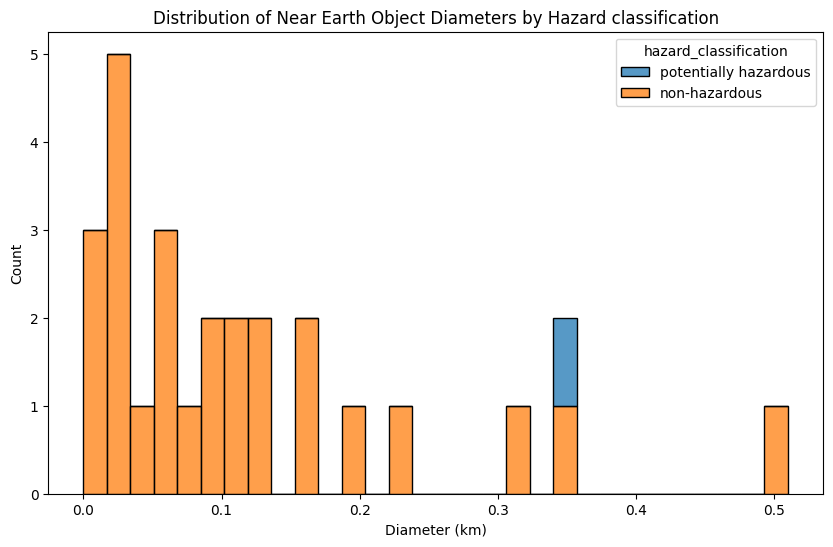

In [0]:
'''histogram graph showing distribution of Near Earth Object diameters by hazard classification'''

plt.figure(figsize=(10,6))
sns.histplot(data=neo_pd, x="diameter_km", hue="hazard_classification", multiple="stack", bins=30)
plt.title("Distribution of Near Earth Object Diameters by Hazard classification")
plt.xlabel("Diameter (km)")
plt.ylabel("Count")
plt.show()


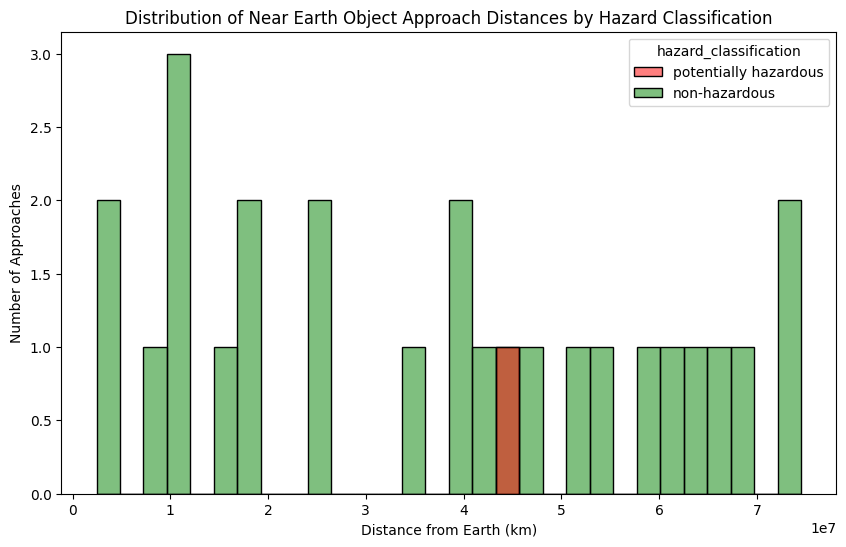

In [0]:
'''histogram showing distribution of approach distances by hazard'''
plt.figure(figsize=(10,6))
sns.histplot(data=approach_pd, x='distance_from_earth_km', hue='hazard_classification', bins=30, palette={'potentially hazardous': 'red', 'non-hazardous': 'green'})
plt.title("Distribution of Near Earth Object Approach Distances by Hazard Classification")
plt.xlabel("Distance from Earth (km)")
plt.ylabel("Number of Approaches")
plt.show()


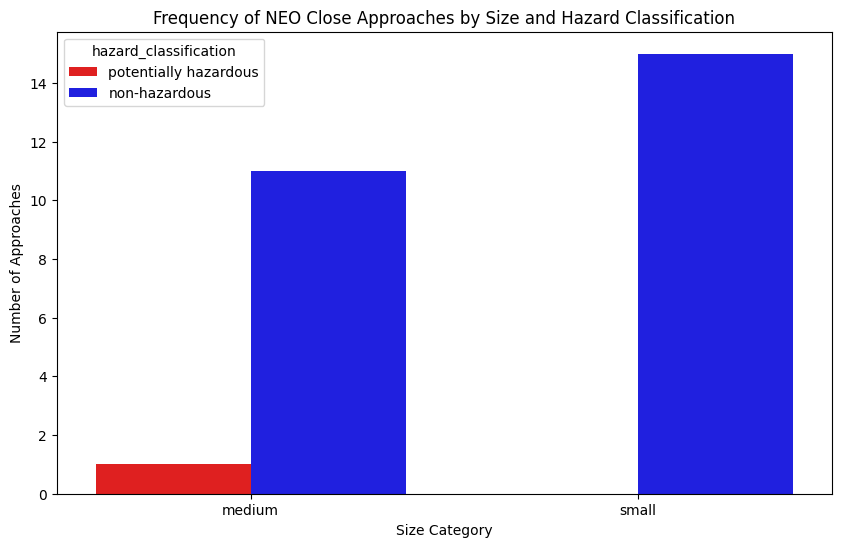

In [0]:
'''bar chart showing number of approaches by size category'''
plt.figure(figsize=(10,6))
sns.countplot(data=approach_pd, x='size_category', hue='hazard_classification',palette={'potentially hazardous': 'red', 'non-hazardous': 'blue'})
plt.title("Frequency of Near Earth Object Approaches by Size and Hazard Classification")
plt.xlabel("Size Category")
plt.ylabel("Number of Approaches")
plt.show()


In [0]:
%sql
-- display all required data in one table from 25 years before and after current date
SELECT
    n.id AS object_id,
    n.name AS object_name,
    n.diameter_km AS object_size_km,
    c.size_category AS size_category,
    c.distance_from_earth_km AS distance_from_earth_km,
    c.distance_category AS distance_category,
    ROUND(n.orbital_period_minutes,2) AS orbital_period_minutes,
    c.close_approach_date AS approach_date,
    n.hazard_classification AS hazard_classification
FROM near_earth_objects n
JOIN close_approaches_with_earth c
  ON n.id = c.neo_id
WHERE
  CAST(c.close_approach_date AS DATE) BETWEEN DATE_SUB(CURRENT_DATE(), 25 * 365) AND DATE_ADD(CURRENT_DATE(), 25 * 365)                                  
ORDER BY c.close_approach_date DESC
LIMIT 10;


object_id,object_name,object_size_km,size_category,distance_from_earth_km,distance_category,orbital_period_minutes,approach_date,hazard_classification
3553060,(2010 XT10),0.02,small,7.356378239E7,distant,330,2015-09-08,non-hazardous
3727181,(2015 RO36),0.11,medium,8086032.0,moderate_distance,12,2015-09-08,non-hazardous
2465633,465633 (2009 JR5),0.35,medium,4.529029823E7,distant,159,2015-09-08,potentially hazardous
3726710,(2015 RC),0.06,small,4027962.7,moderate_distance,4,2015-09-08,non-hazardous
3727639,(2015 RN83),0.19,medium,2.519517736E7,distant,66,2015-09-08,non-hazardous
3426410,(2008 QV11),0.23,medium,3.876455855E7,distant,126,2015-09-08,non-hazardous
3747356,(2016 EK158),0.34,medium,4.195849768E7,distant,142,2015-09-08,non-hazardous
3731587,(2015 UG),0.12,medium,1.694046102E7,distant,36,2015-09-08,non-hazardous
3730577,(2015 TX237),0.09,small,1.189660243E7,distant,21,2015-09-08,non-hazardous
3758838,(2016 RT),0.06,small,2.55371982E7,distant,67,2015-09-08,non-hazardous


In [0]:
%sql
-- query to show the size, orbital time and approach distance of neo objects
SELECT 
    n.id AS object_id,
    n.name AS object_name,
    n.diameter_km AS object_size_km,
    n.orbital_period_minutes AS orbital_period_minutes,
    c.distance_from_earth_km AS approach_distance_km
FROM near_earth_objects n
JOIN close_approaches_with_earth c
ON n.id = c.neo_id
order by distance_from_earth_km
limit 10;

object_id,object_name,object_size_km,orbital_period_minutes,approach_distance_km
3726788,(2015 RG2),0.02,2,2450214.65
3726710,(2015 RC),0.06,4,4027962.7
3727181,(2015 RO36),0.11,12,8086032.0
3727036,(2015 RL35),0.02,17,1.035919367E7
3727663,(2015 RY83),0.06,20,1.144272884E7
3730577,(2015 TX237),0.09,21,1.189660243E7
3727179,(2015 RH36),0.08,34,1.63567259E7
3731587,(2015 UG),0.12,36,1.694046102E7
3759690,(2016 RN41),0.0,40,1.803134071E7
3727639,(2015 RN83),0.19,66,2.519517736E7


In [0]:
%sql
-- show data grouped by distance category and size category ordered by the count of objects
SELECT 
    c.distance_category,
    c.size_category,
    COUNT(*) AS approach_count,
    ROUND(AVG(c.distance_from_earth_km),2) AS avg_distance_km,
    ROUND(AVG(n.orbital_period_minutes),2) AS avg_orbital_period_minutes,
    c.hazard_classification
FROM close_approaches_with_earth c
JOIN near_earth_objects n
ON c.neo_id = n.id
GROUP BY distance_category, size_category, c.hazard_classification
ORDER BY approach_count DESC;

distance_category,size_category,approach_count,avg_distance_km,avg_orbital_period_minutes,hazard_classification
distant,small,13,3.775534919E7,138.54,non-hazardous
distant,medium,10,4.61073564E7,171.6,non-hazardous
distant,medium,1,4.529029823E7,159.0,potentially hazardous
close,small,1,2450214.65,2.0,non-hazardous
moderate_distance,medium,1,8086032.0,12.0,non-hazardous
moderate_distance,small,1,4027962.7,4.0,non-hazardous
